In [1]:
import os
import sys
import pickle
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix as confusion

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torch.utils.data.dataloader import DataLoader


In /home/hensden/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/hensden/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/hensden/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


### Preprocessing

In [2]:
def get_mean_std():
    train_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
    train_set = CIFAR10(root='dataset/', train=True, download=True, transform=train_transform)
    mean = tuple(train_set.data.mean(axis=(0,1,2))/255)
    std = tuple(train_set.data.std(axis=(0,1,2))/255)
    return mean,std


### Load Dataset
Get Train, Val and Test splits

In [3]:
# Training and Validation Split (10%)
mean, std = get_mean_std()
composed_tranforms_train = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomCrop(32),
        torchvision.transforms.RandomHorizontalFlip(0.2),
        torchvision.transforms.RandomVerticalFlip(0.2),
        torchvision.transforms.RandomRotation(15),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean, std)
    ]
)
composed_tranforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean, std)
    ]
)

train_val = CIFAR10(root='dataset/', download=True, transform=composed_tranforms_train)
source_labels = train_val.classes
torch.manual_seed(24)
train, val = torch.utils.data.random_split(train_val, [45000, 5000])
# Test Split
test  = CIFAR10(root='dataset/', train=False, transform=composed_tranforms)


print(train_val)
print(test)
print([{i:j} for i,j in enumerate(source_labels)])


kwargs = {
    'batch_size':64,
    'shuffle':True,
    'pin_memory':True,
    'num_workers':1
}
train_loader = DataLoader(train,**kwargs)
kwargs['shuffle'] = False
val_loader   = DataLoader(val,  **kwargs)
test_loader  = DataLoader(test, **kwargs)


Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: dataset/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=None)
               RandomHorizontalFlip(p=0.2)
               RandomVerticalFlip(p=0.2)
               RandomRotation(degrees=(-15, 15), resample=False, expand=False)
               ToTensor()
               Normalize(mean=(0.49139967861519607, 0.48215840839460783, 0.44653091444546567), std=(0.24703223246328176, 0.24348512800005648, 0.26158784172796473))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: dataset/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.49139967861519607, 0.48215840839460783, 0.44653091444546567), std=(0.24703223246328176, 0.24348512800005648, 0.26158784172796473))
           )
[{0: 'airplane'}, {1: 'automobi

### Choose Device

In [4]:
is_gpu = torch.cuda.is_available()
device = torch.device('cpu')
if is_gpu:
    device = torch.device('cuda')
    

print("Device to be used: {}".format(device))

Device to be used: cuda


### Utility Functions

In [5]:
def accuracy(op, labels):
    _, preds = torch.max(op, dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

def train_step(op, labels):
    return F.cross_entropy(op, labels)
    
    
def val_step(op, labels):
    return {
        'val_loss': F.cross_entropy(op, labels).detach(),
        'val_acc': accuracy(op, labels)
    }

def de_normalize(tensor):
    mean, std = get_mean_std()

    for t, m, s in zip(tensor,mean,std):
            t.mul_(s).add_(m)
    return tensor

def display(good_examples):
    L = len(good_examples)
    fig = plt.figure(figsize=(15,5))
    for i in range(L):
        plt.subplot(1,L,i+1)
        img = good_examples[i]['image']
        img = np.transpose(img, (1,2,0))
        plt.imshow(img)
        plt.title("GT: {}, PRED: {}".format(
            num2word[int(good_examples[i]['gt'])],
            num2word[good_examples[i]['pred']]
        ))

def get_samples(x,y):
    ans = [-1, -1]
    for i in range(x.shape[0]):
        if x[i]!=y[i]:
            ans[0] = i
            break
    for i in range(x.shape[0]):
        if x[i]==y[i]:
            ans[1] = i
            break
    return ans

    
            
        

### Model Speicifications

In [6]:
class FlixNet(nn.Module):
    def __init__(self):
        super(FlixNet, self).__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(64, 64, 5, 1, 2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(128,128,5),
            nn.ReLU(),
            nn.AvgPool2d(2,2)
        )
        
        self.dense_model = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
        
    def forward(self, databatch):
        y = self.conv_block_1(databatch)
        y = self.conv_block_2(y)
        y = self.conv_block_3(y)
        y = torch.flatten(y, 1)
        y = self.dense_model(y)
        return y
           

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    val_history = []
    train_history = []
    best_val = -float('inf')
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        tr = []
        tra = []
        for chunk in train_loader:
            data, labels = chunk
            data = data.to(device)
            labels = labels.to(device)
            op = model(data)
            loss = train_step(op, labels)
            acc = accuracy(op, labels)
            tr.append(float(loss))
            tra.append(float(acc))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        tr_loss = np.array(tr).mean()
        tr_acc  = np.array(tra).mean()
        train_history.append({'tr_loss': tr_loss, 'tr_acc': tr_acc})
        
        # Validation phase
        outputs = []
        for chunk in val_loader:
            data, labels = chunk
            data = data.to(device)
            labels = labels.to(device)
            op = model(data)
            outputs.append(val_step(op, labels))
        
        loss = torch.stack([it['val_loss'] for it in outputs]).mean()
        acc = torch.stack([it['val_acc'] for it in outputs]).mean()
        res = {'val_loss': loss.item(), 'val_acc': acc.item()}
        if float(res['val_acc']) > best_val and epoch>7:
            torch.save(model.state_dict(), 'best.pth')
        
        print("Epoch [{}], tr_acc: {:.4f}, val_acc: {:.4f}".\
              format(epoch, tr_acc, res['val_acc']))
        val_history.append(res)
    return train_history, val_history

### Training and Validation 

In [7]:
flixnet = FlixNet()
net = flixnet.to(device)
print(net)
epochs = 30
tr_info, val_info = fit(epochs, 0.00001, net, train_loader, val_loader)



FlixNet(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (dense_model): Sequential(
    (0): Linear(in

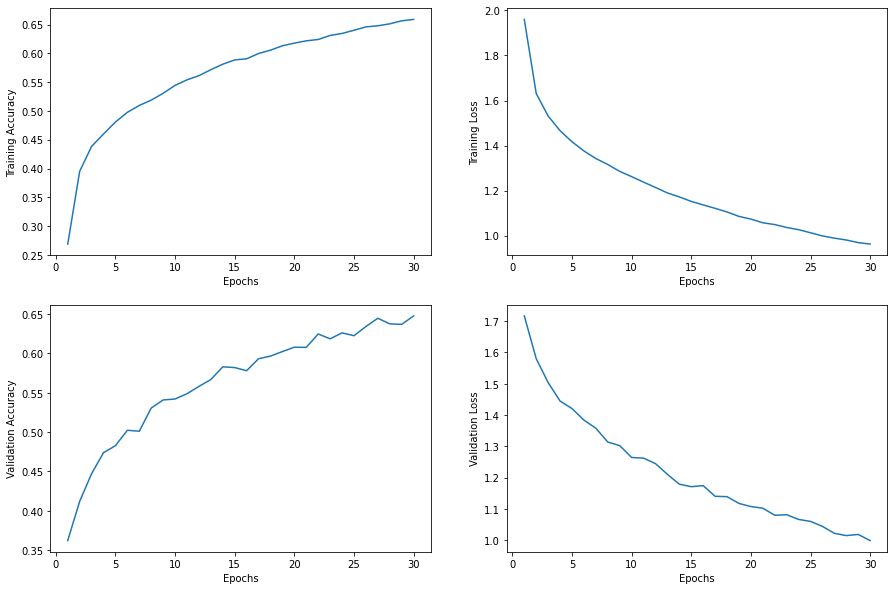

In [8]:

tr_loss, tr_acc, val_loss, val_acc = [], [], [], []
x_axis = range(1, epochs+1)
for info in tr_info:
    tr_loss.append(info['tr_loss'])
    tr_acc.append(info['tr_acc'])
    
for info in val_info:
    val_loss.append(info['val_loss'])
    val_acc.append(info['val_acc'])

fig = plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(x_axis, tr_acc)
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")

plt.subplot(2, 2, 2)
plt.plot(x_axis, tr_loss)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")

plt.subplot(2, 2, 3)
plt.plot(x_axis, val_acc)
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")

plt.subplot(2, 2, 4)
plt.plot(x_axis, val_loss)
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")

plt.show()

### Testing

In [9]:
test_model = FlixNet()
test_model.load_state_dict(torch.load('best.pth'))
test_model.eval()
test_model.to(device)

FlixNet(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (dense_model): Sequential(
    (0): Linear(in

In [10]:
y_pred = []
y_gt = []
acc = []
bad_examples = []
good_examples = []
for i, chunk in enumerate(test_loader):
    data, labels = chunk
    data_g = data.to(device)
    labels_g = labels.to(device)
    y = test_model(data_g)
    
    
    _, pred = torch.max(y, dim=1)
    y_pred.append(pred.cpu().tolist())
    y_gt.append(labels.tolist())
    acc.append(accuracy(y, labels_g))
    if i % 30 == 0:
        if is_gpu:
            pred = pred.cpu()
        bad, good = get_samples(np.array(pred), np.array(labels))
        if bad is not -1:
            bad_examples.append({'image':de_normalize(data[bad]), 'gt':labels[bad], 'pred':int(pred[bad])})
        if good is not -1:
            good_examples.append({'image':de_normalize(data[good]), 'gt':labels[good], 'pred':int(pred[good])})

test_accuracy = np.array(acc).mean()
print("Testing Accuracy is: {}%".format(round(100*test_accuracy, 5)))



Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Testing Accuracy is: 68.9789%


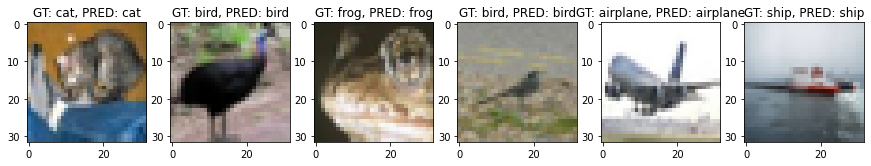

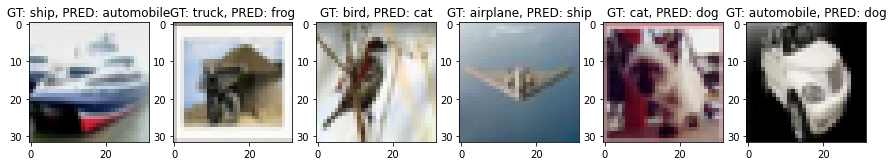

In [11]:
source_labels = train_val.classes
num2word = {}
for i,j in enumerate(source_labels):
    num2word[i] = j
display(good_examples)
display(bad_examples)


In [12]:
Y_PRED = np.array([])
for lis in y_pred:
    Y_PRED = np.hstack((Y_PRED,np.array(lis)))
Y_GT = np.array([])
for lis in y_gt:
    Y_GT = np.hstack((Y_GT,np.array(lis)))
conf = confusion(Y_GT, Y_PRED)
print(source_labels)


['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [13]:
print('{:10}'.format(" "), end=' ')
for i in range(10):
    print(' {:5}'.format(source_labels[i][:5]), end='')
        
print()
for i, row in enumerate(conf):
    print('{:10}'.format(source_labels[i]), end=' ')
    for val in row:
        print('{:5}'.format(val), end=' ')
    print()

            airpl autom bird  cat   deer  dog   frog  horse ship  truck
airplane     725    29    56    11    14     5    12    13    92    43 
automobile    20   816     3     3     5     3     6     6    38   100 
bird          76     9   540    47   112    59    78    48    19    12 
cat           19     7    78   410    77   197   100    52    30    30 
deer          22     5    53    45   654    25    65   107    17     7 
dog           20     7    53   148    59   609    23    57    14    10 
frog           6     5    40    48    57    19   797    12    11     5 
horse         20     6    32    29    72    69     4   729    10    29 
ship          79    40     7     7     9     4     7     8   810    29 
truck         30    83     6     5     7     3     9    11    44   802 
